In [1]:
using Pkg
for p in ["Knet", "Plots", "IterTools"]
    if !haskey(Pkg.installed(),p)
        Pkg.add(p);
    end
end
using DelimitedFiles
using Knet: KnetArray, accuracy, progress, minibatch, cycle, adam, sgd
using Plots
using IterTools: ncycle, takenth, take
using Base.Iterators: flatten
using LinearAlgebra

include("utils.jl")
include("models.jl")

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at utils.jl:3
└ @ Core /home/ec2-user/dl/utils.jl:3


In [2]:
# Load data
adj, features, labels, idx_train, idx_val, idx_test = load()

(K32(2708,2708)[0.16666667⋯], K32(1433,2708)[0.0⋯], Int32[0 1 … 0 0; 0 0 … 0 0; … ; 0 0 … 1 0; 0 1 … 0 0], 1:140, 200:500, 500:1500)

In [3]:
# TODO: take user inputs
struct args
    epochs
    lr
    weight_decay
    hidden
    pdrop
end

arguments = args(200, 0.01, 5e-4, 16, 0.5)

# Model and optimizer
model = GCN(size(features,1),
            arguments.hidden,
            size(labels,2),
            adj,
            arguments.pdrop)

GCN(GCLayer(P(KnetArray{Float32,2}(16,1433)), P(KnetArray{Float32,1}(16)), K32(2708,2708)[0.16666667⋯], NNlib.relu), GCLayer(P(KnetArray{Float32,2}(7,16)), P(KnetArray{Float32,1}(7)), K32(2708,2708)[0.16666667⋯], identity), 0.5)

In [4]:
output = model(features)

7×2708 KnetArray{Float32,2}:
 -0.0012994    -0.00164048   -0.00144811   …  -0.00338891  -0.00534677 
  0.00206938    0.000607427   0.000135247      0.00225486   0.00831833 
  0.00512618    0.00180789    0.00367963       0.00391796   0.00868854 
 -0.0041851    -0.00201418   -0.00164701      -0.00231158  -0.000881421
 -0.000147562   0.000853195   0.00032024       0.0115567    0.0134857  
 -0.00311022   -0.000435965   0.000764597  …  -0.00331202  -0.00699863 
  0.00216654    0.000652345   0.00230904       0.00297375   0.00758509 

In [5]:
labels_decoded = mapslices(argmax, labels ,dims=2)[:]

2708-element Array{Int64,1}:
 2
 5
 4
 4
 7
 7
 3
 2
 2
 3
 2
 1
 7
 ⋮
 3
 7
 7
 7
 7
 2
 1
 1
 1
 1
 6
 2

In [6]:
nll(output[:,idx_train], labels_decoded[idx_train])

1.9456105f0

In [7]:
accuracy(output[:,idx_train], labels_decoded[idx_train])

0.11428571428571428

In [8]:
using AutoGrad
J = @diff model(features, labels_decoded)

T(1.9454521)

In [9]:
grad(J, params(model)[1])

16×1433 KnetArray{Float32,2}:
 -8.87584e-6   3.35843e-5   2.61724e-5  …   8.3305e-6    7.7627e-6 
 -4.77678e-6  -1.88114e-5  -4.12953e-5     -3.17108e-5  -5.49557e-5
  8.78419e-7  -2.28516e-5   2.91588e-5     -1.31815e-5  -2.05659e-6
 -5.23727e-6   2.77096e-5   4.97344e-5     -1.51076e-5   6.15354e-5
  5.76677e-6   5.5167e-5    6.62743e-5     -3.63205e-5   2.84036e-5
  1.61982e-5   4.40275e-5  -7.23436e-5  …  -4.35716e-5  -2.19251e-5
 -4.94127e-6   2.27417e-5   4.0305e-5       5.56969e-5   3.0181e-6 
 -1.10811e-5  -1.4249e-5   -4.27852e-5     -3.35779e-5  -3.11396e-5
  8.34513e-6  -9.44345e-6  -1.68016e-5     -3.39499e-5  -2.22156e-5
  2.80108e-5   5.01894e-6  -4.78627e-6     -7.96994e-5  -2.17418e-5
 -6.55712e-6  -4.59112e-5  -7.6508e-5   …  -2.498e-5    -2.41524e-5
 -2.40687e-6   2.20697e-5   3.13166e-5      1.21745e-5  -9.3428e-6 
  3.75469e-6  -9.4992e-6    4.87761e-5      9.5954e-6    1.18497e-5
 -1.78496e-6   2.08932e-5  -2.41437e-6     -6.30187e-6  -7.06566e-7
 -8.66798e-6  -4.1

In [10]:
accuracy(output[:,idx_train], labels_decoded[idx_train])

0.11428571428571428

In [11]:
xtrn = features[:,idx_train]

1433×140 KnetArray{Float32,2}:
 0.0   0.0        0.0        0.0  0.0  …  0.0  0.0  0.0        0.0  0.0  0.0
 0.0   0.0        0.0        0.0  0.0     0.0  0.0  0.0        0.0  0.0  0.0
 0.0   0.0        0.0        0.0  0.0     0.0  0.0  0.0        0.0  0.0  0.0
 0.0   0.0        0.0        0.0  0.0     0.0  0.0  0.0        0.0  0.0  0.0
 0.0   0.0        0.0        0.0  0.0     0.0  0.0  0.0        0.0  0.0  0.0
 0.0   0.0        0.0        0.0  0.0  …  0.0  0.0  0.0        0.0  0.0  0.0
 0.0   0.0        0.0        0.0  0.0     0.0  0.0  0.0        0.0  0.0  0.0
 0.0   0.0        0.0        0.0  0.0     0.0  0.0  0.0        0.0  0.0  0.0
 0.0   0.0        0.0        0.0  0.0     0.0  0.0  0.0        0.0  0.0  0.0
 0.0   0.0        0.0        0.0  0.0     0.0  0.0  0.0        0.0  0.0  0.0
 0.0   0.0        0.0        0.0  0.0  …  0.0  0.0  0.0        0.0  0.0  0.0
 0.0   0.0        0.0        0.0  0.0     0.0  0.0  0.0        0.0  0.0  0.0
 0.0   0.0588235  0.0        0.0  0.0     0.0

In [12]:
ytrn = labels_decoded[idx_train]

140-element Array{Int64,1}:
 2
 5
 4
 4
 7
 7
 3
 2
 2
 3
 2
 1
 7
 ⋮
 4
 1
 3
 7
 4
 2
 2
 5
 5
 7
 7
 1

In [13]:
dtrn =  minibatch(features, labels_decoded[:], length(labels_decoded))
#dtrn =  minibatch(xtrn, ytrn, length(ytrn))

Data{Tuple{KnetArray{Float32,2},Array{Int64,1}}}(K32(1433,2708)[0.0⋯], [2 5 … 6 2], 2708, 2708, false, 1, 1:2708, false, (1433, 2708), (2708,), KnetArray{Float32,2}, Array{Int64,1})

In [14]:
function trn_loss(x,y)
    nll(model(x)[:,idx_train], y[idx_train])
end

function tst_loss(x,y)
    nll(model(x)[:,idx_test], y[idx_test])
end

tst_loss (generic function with 1 method)

In [16]:
function train_with_results(model, dtrn, epoch, lr)
    training = adam(model, ncycle(dtrn, epoch), lr=lr)
    snapshot() = model(dtrn)
    snapshots = (snapshot() for x in takenth(progress(training),length(dtrn)))
    res = collect(flatten(snapshots))
    return res
end

train_with_results (generic function with 1 method)

┣████████████████████┫ [100.00%, 200/200, 00:04/00:04, 56.58i/s] 


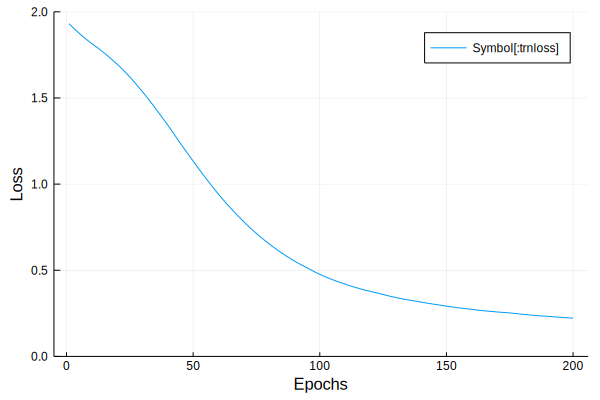

In [17]:
results = train_with_results(model, dtrn, arguments.epochs, arguments.lr)
trnloss = Array{Float32}(results)
plot(trnloss, ylim=(0.0,2.0),labels=[:trnloss],xlabel="Epochs",ylabel="Loss")

In [18]:
output = model(features)
accuracy(output[:,idx_train], labels_decoded[idx_train])

0.9214285714285714